<a href="https://colab.research.google.com/github/mpgl/dendrify-paper/blob/main/Fig-2-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
> *In this interactive notebook, we present and briefly discuss the Python code needed to reproduce the model and the results shown in Figure 2 of our manuscript. Detailed tutorials of all Dendrify's features will be available soon in our [GitHub](https://github.com/mpgl/dendrify-paper) repository.*
<br>

## Setup

In [ ]:
#@title Install dependencies (might take a few seconds)
import os
if 'dendrify' in os.getcwd():
    pass
else:
    !git clone https://github.com/mpgl/dendrify-paper.git --quiet
    os.chdir('dendrify-paper')

!pip install brian2 --quiet


In [ ]:
#@title Imports and settings
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt) # Generally a better practise than * imports
from dendrify import Soma, Dendrite, NeuronModel

b.prefs.codegen.target = 'numpy' # Improves performance significantly here

# @title Figure settings
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, orange, green])
          }

b.rcParams.update(params)

## Create model

> *Let's first build a 3-compartment toy model with passive dendrites. With this basic example our goal is:*
>
>
> - *To illustrate Dendrify's simplistic, Lego-style code approach used to describe any reduced model's morphology and properties.*
>
>- *To show that even rudimentary compartmental models perform functions that cannot be captured by point-neuron models often used in SNNs.*




In [ ]:
# create soma
soma = Soma('soma', model='leakyIF', length=25*um, diameter=25*um)

# create apical dendrite
apical = Dendrite('apical', length=250*um, diameter=2*um)

# create basal dendrite
basal = Dendrite('basal', length=150*um, diameter=2*um)

# add noise
apical.noise(tau=20*ms, sigma=3*pA, mean=0*pA)
basal.noise(tau=20*ms, sigma=3*pA, mean=0*pA)

# add synapses
apical.synapse('AMPA', pre='cortex', g=1*nS, t_decay=2*ms)
apical.synapse('NMDA', pre='cortex', g=1*nS, t_decay=60*ms)

# merge compartments into a  neuron model and set its properties
edges = [(soma, apical, 10*nS), (soma, basal, 10*nS)]
pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=50*uS/(cm**2),
                          v_rest=-70*mV, r_axial=150*ohm*cm,
                          scale_factor=3, spine_factor=1.5)

# create a Brian NeuronGroup and link it to the neuron model
pyr_group = b.NeuronGroup(3, model=pyr_model.equations, method='euler',
                          threshold='V_soma > -40*mV', reset='V_soma = -50*mV',
                          refractory=3*ms, namespace=pyr_model.parameters)
pyr_model.link(pyr_group)

> *We can inspect what Dendrify created for us by simply printing a NeuronModel object:*

In [ ]:
print(pyr_model)

> *Our model now looks somewhat like this:*
>
><p align="center">
    <img src="https://github.com/mpgl/dendrify-paper/blob/main/graphics/1.png?raw=true" alt="model" width="25%">
></p>
>
> *Let's use it to replicate the experiments shown in Figure 2*

## Panel B 

In [ ]:
# Set monitors to record membrane voltages
M = b.StateMonitor(pyr_group, ["V_soma", "V_apical", "V_basal"], record=True)

# Set input current amplitude
I = 100 * pA

# First 100 ms -> no input
b.run(100*ms)

# Next 400 ms -> square pulse of I amplitude
pyr_group.I_ext_soma[0] = I
pyr_group.I_ext_apical[1] = I
pyr_group.I_ext_basal[2] = I
b.run(400*ms)

# Next 200 ms -> no input to let membranes return to Vrest
pyr_group.I_ext_soma[0] = 0 * pA
pyr_group.I_ext_apical[1] = 0 * pA
pyr_group.I_ext_basal[2] = 0 * pA
b.run(200*ms)

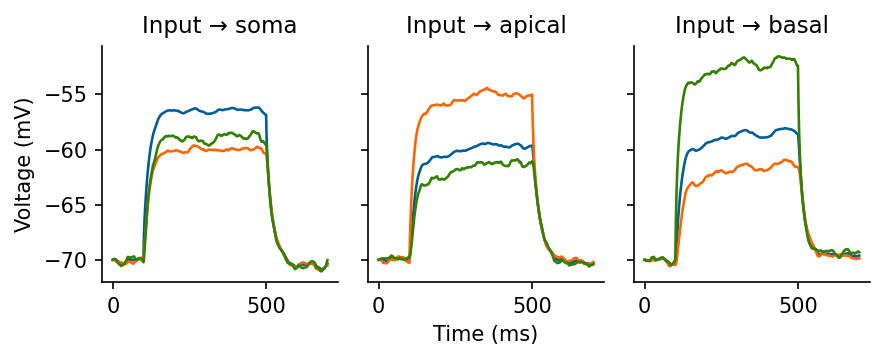

In [8]:
# @title Plot output
time = M.t/ms
vs = M.V_soma/mV
va = M.V_apical/mV
vb = M.V_basal/mV

fig, axes = b.subplots(1, 3, figsize=[6, 2.5], sharex=True, sharey=True)
ax0, ax1, ax2 = axes

for i, ax in enumerate([ax0, ax1, ax2]):
    for v in vs, va, vb:
        ax.plot(time, v[i])

ax0.set_ylabel('Voltage (mV)')
ax1.set_xlabel('Time (ms)')

ax0.set_title("Input \u2192 soma")
ax1.set_title("Input \u2192 apical")
ax2.set_title("Input \u2192 basal")

fig.tight_layout()

> *Notice the electrical segmentation caused by the attenuation of currents traveling along the somatodendritic axis. Although this property may seem undesirable, it allows each compartment to operate semi-autonomously from the others, thus multiple input integration sites can coexist within a single neuron.*

## Panels C & D